In [1]:
from stacked_hourglass import HumanPosePredictor, hg2, hg8, hg1
from stacked_hourglass.utils.transforms import shufflelr, crop, color_normalize, fliplr, transform
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time, math,os
import PIL.ExifTags as ExifTags
from tqdm import tqdm
import seaborn as sns

# ...load image of a person into a PyTorch tensor...

model = hg8(pretrained=True)
predictor = HumanPosePredictor(model, device='cpu')
root = "/Users/seungyoun/Desktop/DGU/2/공개SW/pytorch-stacked-hourglass-master/dataset"

print("==model loaded==")

RGB_MEAN = torch.as_tensor([0.4404, 0.4440, 0.4327])
RGB_STDDEV = torch.as_tensor([0.2458, 0.2410, 0.2468])
#im = np.asarray(Image.open("./images/test14.jpeg"))
up = os.listdir(root + "/up")
down = os.listdir(root + "/down")
print("up   samples : ",len(up),"\ndown samples : ",len(down))

def predict(path):
    orgImg = Image.open(path)

    try:
        for orientation in ExifTags.TAGS.keys() :
            if ExifTags.TAGS[orientation]=='Orientation' : break
        exif=dict(orgImg._getexif().items())
        if exif[orientation] == 3:
            orgImg=orgImg.rotate(180, expand=True)
        elif exif[orientation] == 6 :
            orgImg=orgImg.rotate(270, expand=True)
        elif exif[orientation] == 8 :
            orgImg=orgImg.rotate(90, expand=True)

    except:
        pass
    im = np.asarray(orgImg)
    img = torch.tensor(im).transpose(0,2)
    img = color_normalize(img, RGB_MEAN, RGB_STDDEV)
    if(img.size(0)==4):
        img = img[:3]

    c,h,w = img.size()
    start = time.time()
    joints = predictor.estimate_joints(img, flip=True)
    end = time.time()
    xs,ys = list(joints[:,0].numpy()), list(joints[:,1].numpy())
    #print("infer time : ",end-start)


    left_antebrachial   = np.array([ys[15]-ys[14],xs[15]-xs[14]])
    left_forearm        = np.array([ys[13]-ys[14],xs[13]-xs[14]])
    left_back           = np.array([ys[7]-ys[13], xs[7]-xs[13]])
    left_arm_angle      = np.inner(left_antebrachial, left_forearm)/(np.linalg.norm(left_antebrachial)*np.linalg.norm(left_forearm))
    left_back_angle     = np.inner(left_forearm, left_back)/(np.linalg.norm(left_forearm)*np.linalg.norm(left_back))

    right_antebrachial  = np.array([ys[10]-ys[11],xs[10]-xs[11]])
    right_forearm       = np.array([ys[12]-ys[10],xs[12]-xs[10]])
    right_back          = np.array([ys[7]-ys[12], xs[7]-xs[12]])
    right_arm_angle     = np.inner(right_antebrachial, right_forearm)/(np.linalg.norm(right_antebrachial)*np.linalg.norm(right_forearm))
    right_back_angle    = np.inner(right_back, right_forearm)/(np.linalg.norm(right_back)*np.linalg.norm(right_forearm))

    left_arm_angle   = np.arccos(left_arm_angle)*360/(np.pi*2)
    left_back_angle  = 180-np.arccos(left_back_angle)*360/(np.pi*2)
    right_arm_angle  = np.arccos(right_arm_angle)*360/(np.pi*2)
    right_back_angle = 180-np.arccos(right_back_angle)*360/(np.pi*2)

    return left_arm_angle,left_back_angle,right_arm_angle,right_back_angle

upDist   = list()
downDist = list()

for i in tqdm(up):
    left_arm_angle,left_back_angle,right_arm_angle,right_back_angle = predict(root+"/up/"+i)
    upDist.append([left_arm_angle, left_back_angle, right_arm_angle, right_back_angle])

for i in tqdm(down):
    left_arm_angle,left_back_angle,right_arm_angle,right_back_angle = predict(root+"/down/"+i)
    downDist.append([left_arm_angle, left_back_angle, right_arm_angle, right_back_angle])


  0%|          | 0/110 [00:00<?, ?it/s]

==model loaded==
up   samples :  110 
down samples :  82


100%|██████████| 82/82 [05:26<00:00,  4.46s/it]


In [2]:
%matplotlib inline

## 올라간 동작 

In [3]:
left_arm_angle   = [theta[0] for theta in upDist]
left_back_angle  = [theta[1] for theta in upDist]
right_arm_angle  = [theta[2] for theta in upDist]
right_back_angle = [theta[3] for theta in upDist]

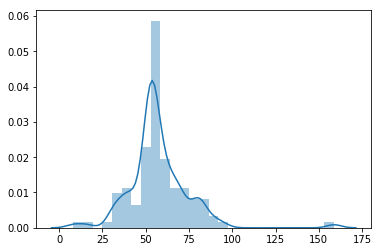

In [4]:
sns.distplot(left_arm_angle)

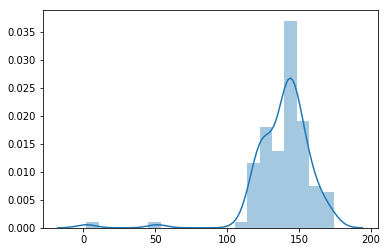

In [5]:
sns.distplot(left_back_angle)

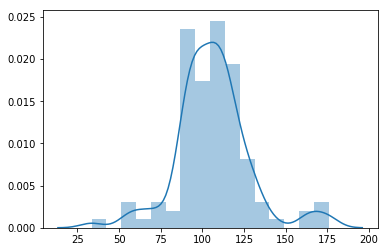

In [10]:
sns.distplot(right_arm_angle)

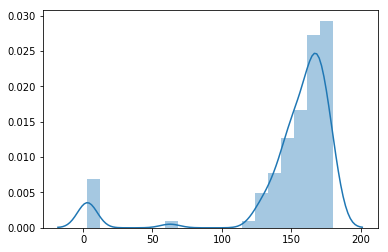

In [6]:
sns.distplot(right_back_angle)

## 내려간 동작

In [7]:
left_arm_angle0   = [theta[0] for theta in downDist]
left_back_angle0  = [theta[1] for theta in downDist]
right_arm_angle0  = [theta[2] for theta in downDist]
right_back_angle0 = [theta[3] for theta in downDist]

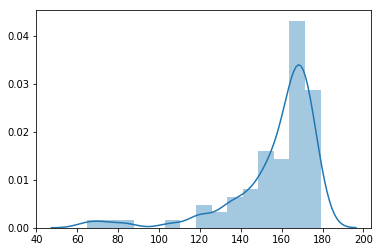

In [13]:
sns.distplot(left_arm_angle0)

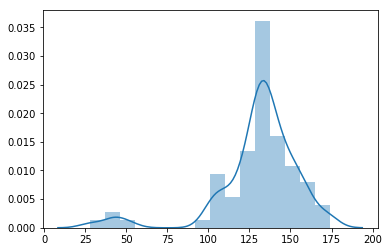

In [14]:
sns.distplot(left_back_angle0)

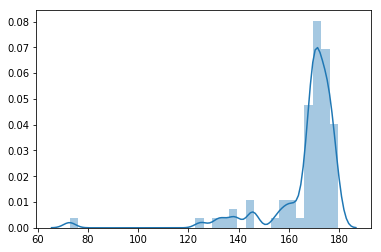

In [15]:
sns.distplot(right_arm_angle0)

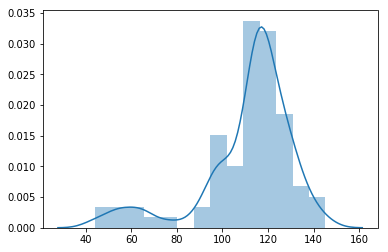

In [16]:
sns.distplot(right_back_angle0)

## 같이 비교해볼까요~?

In [10]:
kwargs = dict(alpha=0.5, bins=20)

왼쪽 팔 각

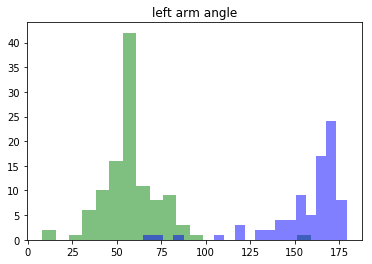

In [11]:
plt.hist(left_arm_angle , **kwargs, color='g', label='Ideal')
plt.hist(left_arm_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='left arm angle')


오른쪽 팔 각

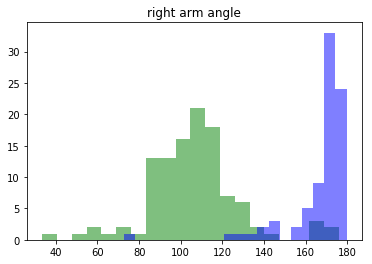

In [12]:
plt.hist(right_arm_angle , **kwargs, color='g', label='Ideal')
plt.hist(right_arm_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='right arm angle')


왼쪽 광배 각

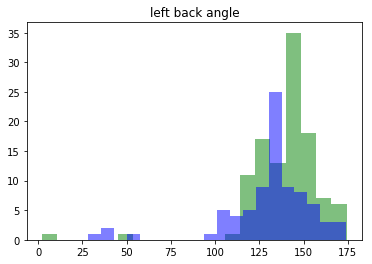

In [13]:
plt.hist(left_back_angle , **kwargs, color='g', label='Ideal')
plt.hist(left_back_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='left back angle')


오른쪽 광배 각

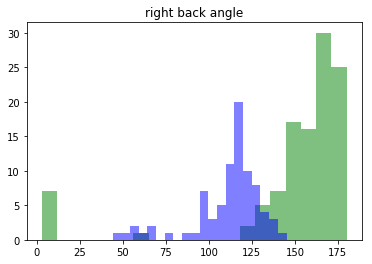

In [14]:
plt.hist(right_back_angle , **kwargs, color='g', label='Ideal')
plt.hist(right_back_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='right back angle')


## Prediction Model

In [33]:
X = upDist+downDist
upCount   = len(upDist)
downCount = len(downDist)
Y = list()
for i in range(upCount):
    Y.append(1)
for i in range(downCount):
    Y.append(0)
X = np.asarray(X)
Y = np.asarray(Y)

In [51]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100,
                      silent=True, objective='binary:logistic',
                      booster='gbtree',
                      n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
                      max_delta_step=0, subsample=1, colsample_bytree=1,
                      colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                      scale_pos_weight=1, base_score=0.5, random_state=0,
                      seed=None, missing=None, **kwargs)

In [53]:
model.fit(X,Y)

XGBClassifier(alpha=0.5, base_score=0.5, bins=20, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [54]:
model.predict(X[122].reshape(1,4))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0])

In [55]:
model.save_model('xgboost.bst')

In [59]:
y_pred = model.predict(X)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Test image

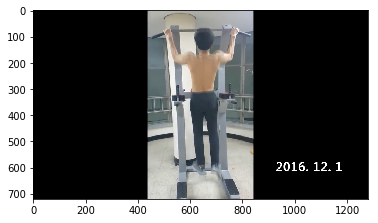

In [98]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

testImage = root+ '/updowntest/test5.jpg'
plt.imshow(mpimg.imread(testImage))

In [99]:
angles = predict(testImage)

In [100]:
pred = model.predict(np.asarray(angles).reshape(1,4))
print(pred)

[0]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
